# **Yi Sun: 6039785979**

# **Interview Mini Project Instagram likes**


In [1]:
from google.colab import drive
import sys
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
drive.mount('/content/drive')
sys.path.append("/content/drive/My Drive/instagram_prediction")
!ls "/content/drive/My Drive/instagram_prediction"

Mounted at /content/drive
 Data  'Interview Mini Project.docx'


# **1. Load Datasets**

In [3]:
# Path to the CSV file and image folder
ig_csv_file_path = "/content/drive/My Drive/instagram_prediction/Data/instagram_data.csv"
image_folder = "/content/drive/My Drive/instagram_prediction/Data/insta_data"

# Load the CSV file
instagram_data = pd.read_csv(ig_csv_file_path)

base_image_path = "/content/drive/My Drive/instagram_prediction/Data/insta_data"
instagram_data['image_path'] = instagram_data['image_path'].apply(lambda x: os.path.join(base_image_path, os.path.basename(x)))

#### a. Visualize Dataset

In [4]:
instagram_data.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,/content/drive/My Drive/instagram_prediction/D...
1,97386,0,1593571666,40934474,/content/drive/My Drive/instagram_prediction/D...
2,145632,0,1593136341,40934474,/content/drive/My Drive/instagram_prediction/D...
3,76461,0,1592981047,40934474,/content/drive/My Drive/instagram_prediction/D...
4,174620,0,1592703461,40934474,/content/drive/My Drive/instagram_prediction/D...


#### b. Visualize image data

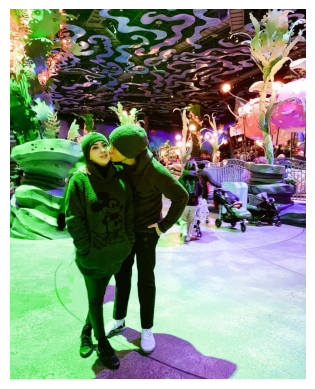

In [5]:
demo_image = Image.open(instagram_data['image_path'][0])
plt.imshow(demo_image)
plt.axis('off')
plt.show()

# **2. Data Visualization**

#### a. Distribution of likes

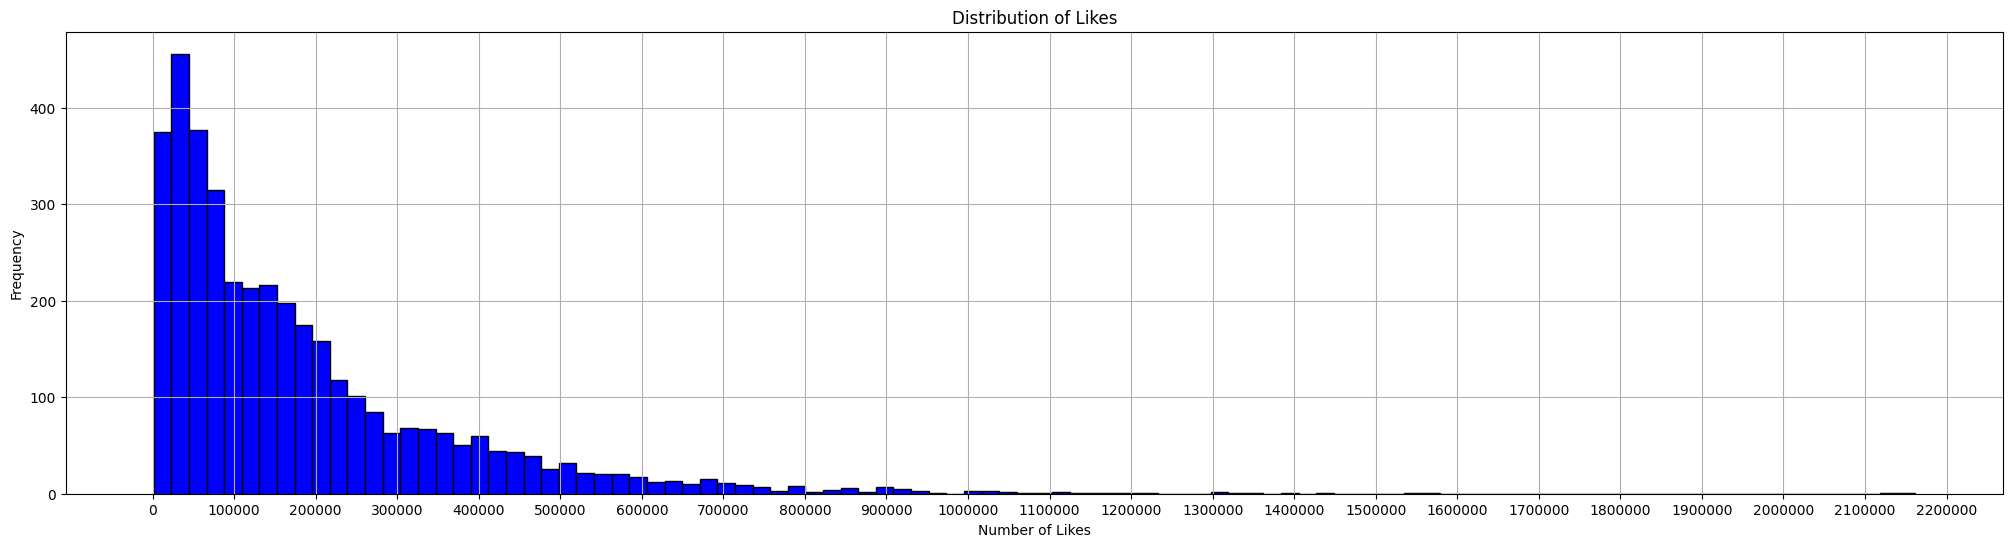

In [12]:
# Plot histogram of the 'likes' column to understand its distribution
plt.figure(figsize=(25, 6))
plt.hist(instagram_data['likes'], bins=100, color='blue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='x')
max_likes = int(instagram_data['likes'].max())
plt.xticks(np.arange(0, max_likes + 100000, 100000))

plt.title('Distribution of Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### b. box plot of likes

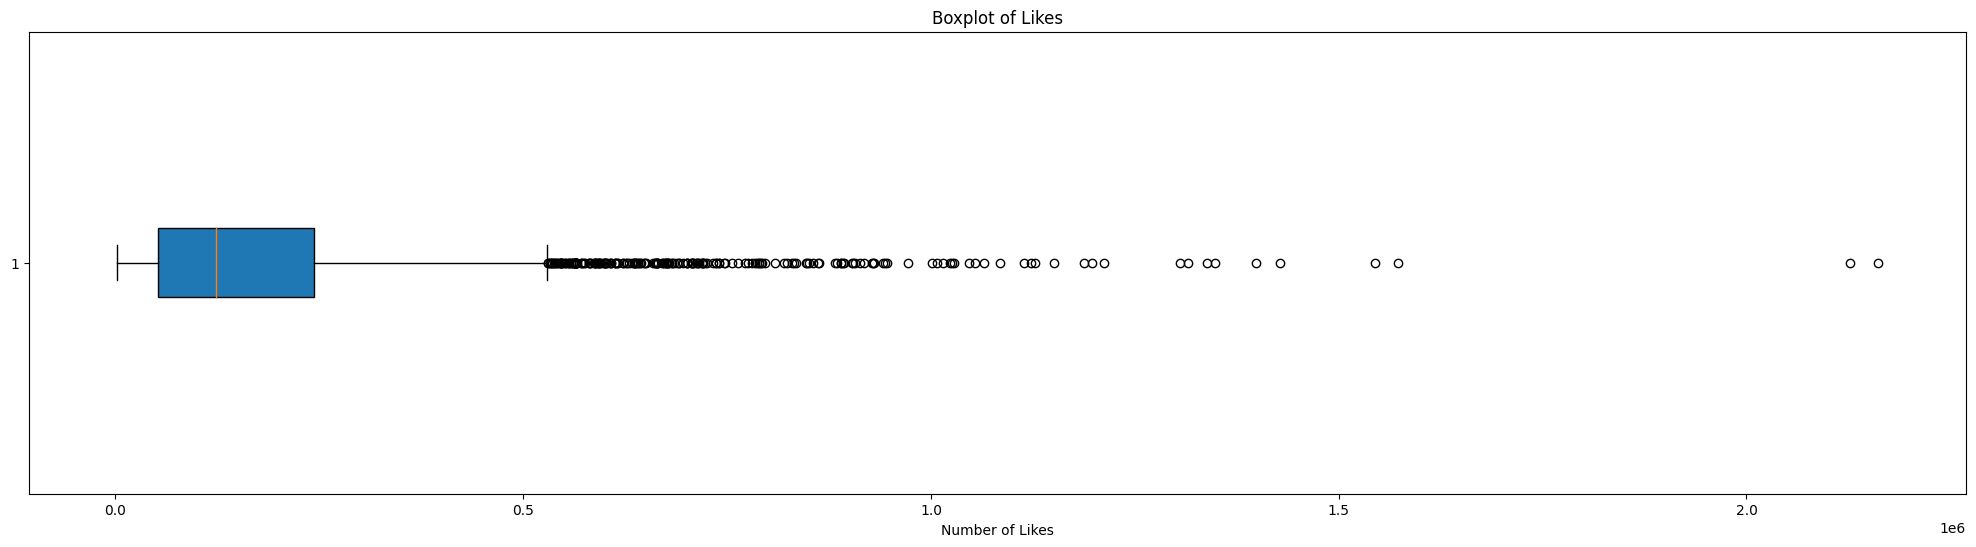

In [11]:
# Boxplot to visualize the spread of likes
plt.figure(figsize=(25, 6))
plt.boxplot(instagram_data['likes'], vert=False, patch_artist=True)
plt.title('Boxplot of Likes')
plt.xlabel('Number of Likes')
plt.show()

#### c. scatter plot of likes vs followers

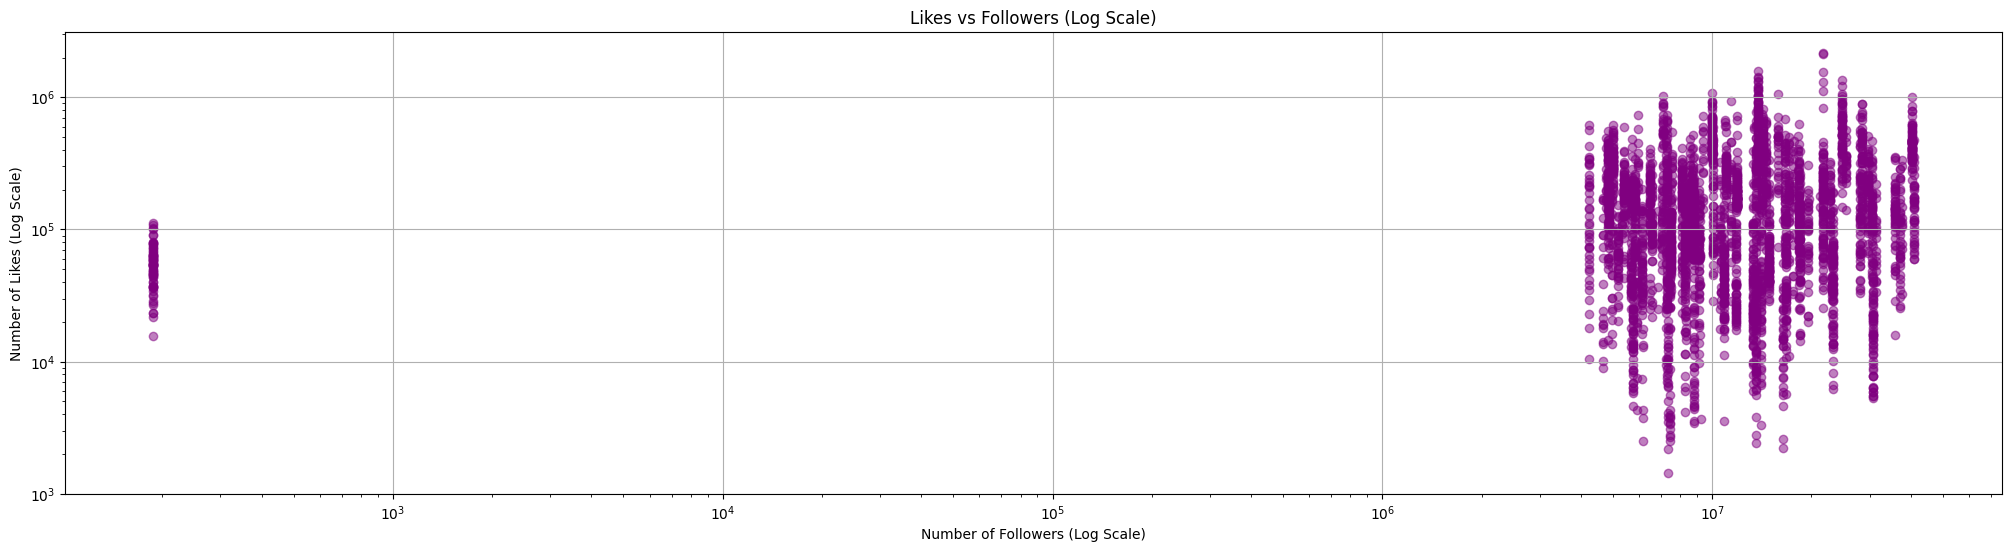

In [276]:
# Scatter plot of likes vs followers with log scale
plt.figure(figsize=(25, 6))
plt.scatter(instagram_data['follower_count_at_t'], instagram_data['likes'], alpha=0.5, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.title('Likes vs Followers (Log Scale)')
plt.xlabel('Number of Followers (Log Scale)')
plt.ylabel('Number of Likes (Log Scale)')
plt.grid(True)
plt.show()


#### d. scatter plot of likes vs comments

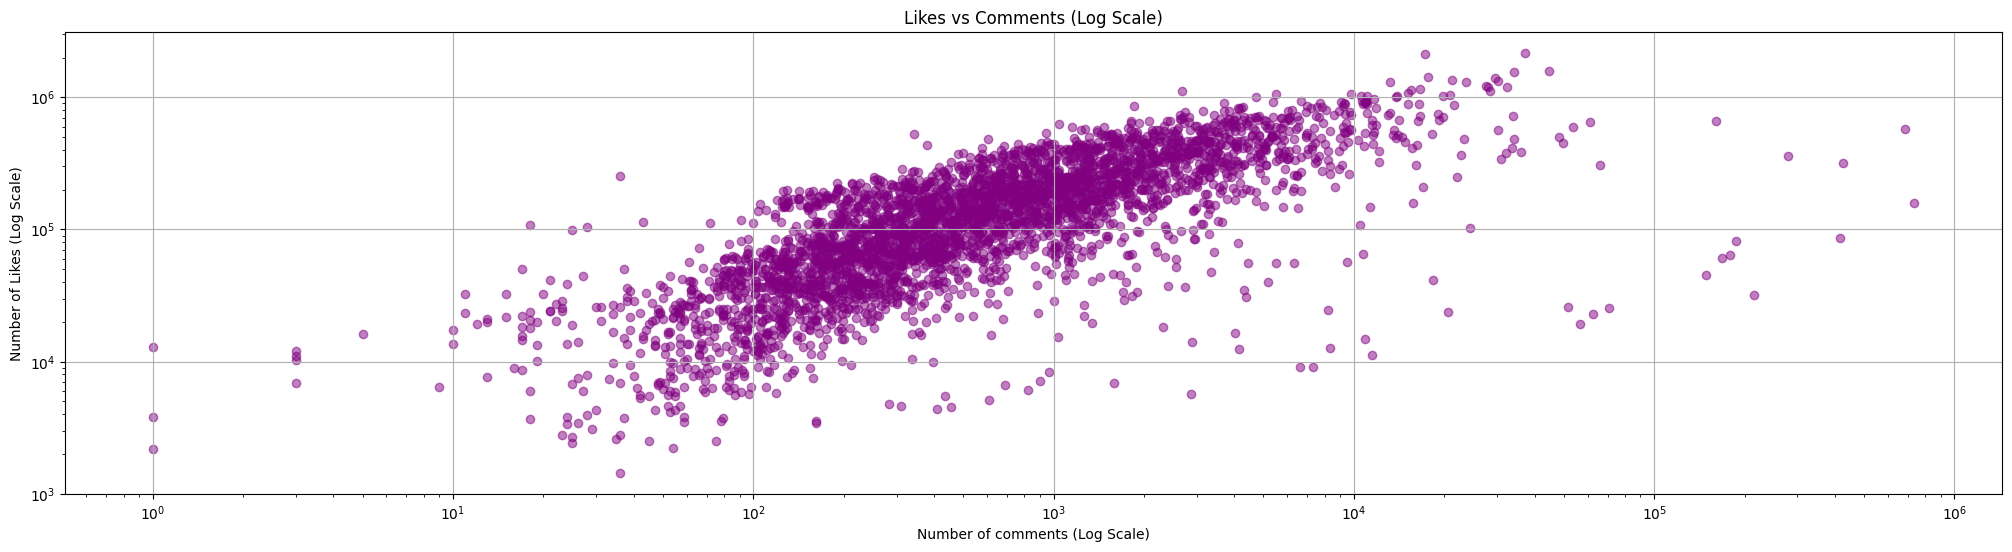

In [277]:
# Scatter plot of likes vs followers with log scale
plt.figure(figsize=(25, 6))
plt.scatter(instagram_data['no_of_comments'], instagram_data['likes'], alpha=0.5, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.title('Likes vs Comments (Log Scale)')
plt.xlabel('Number of comments (Log Scale)')
plt.ylabel('Number of Likes (Log Scale)')
plt.grid(True)
plt.show()

#### e. scatter plot of likes vs time

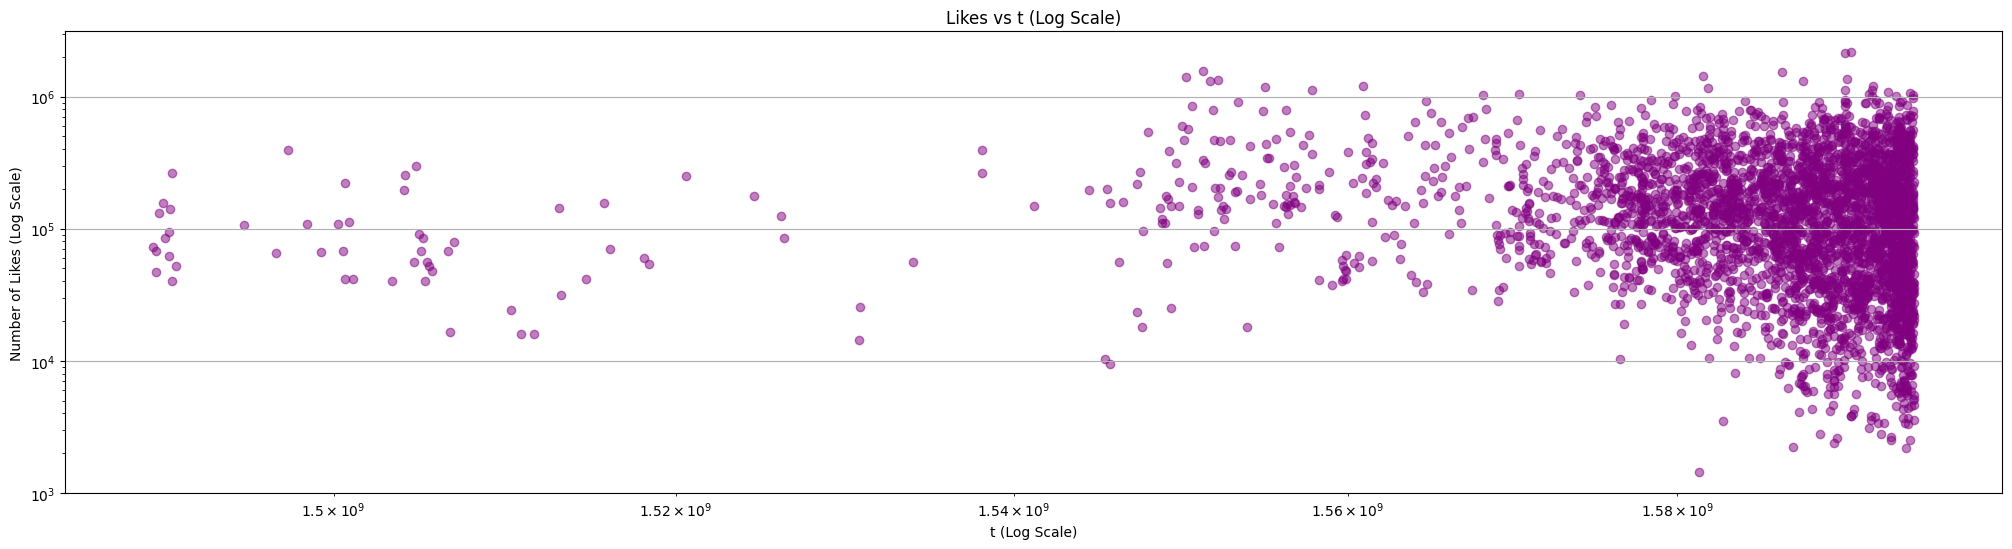

In [281]:
# Scatter plot of likes vs followers with log scale
plt.figure(figsize=(25, 6))
plt.scatter(instagram_data['t'], instagram_data['likes'], alpha=0.5, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.title('Likes vs t (Log Scale)')
plt.xlabel('t (Log Scale)')
plt.ylabel('Number of Likes (Log Scale)')
plt.grid(True)
plt.show()

# **3. Data Cleaning**


#### a. Remove rows with empty cells: None

In [282]:
# Count the number of rows with at least one missing value
missing_rows_count = instagram_data.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {missing_rows_count}")

# Count the number of missing values per column
missing_values_per_column = instagram_data.isnull().sum()
print(missing_values_per_column)

Number of rows with at least one missing value: 0
likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64


#### b. remove outliers for data

In [313]:
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np

# Split data into features (X) and target (y)
features = instagram_data[['no_of_comments', 'follower_count_at_t', 't', 'image_path']]
target = instagram_data['likes']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Now, handle outliers only in the training set
X_train = X_train.copy()

# Apply log transformation to the features in the training set
X_train.loc[:, 'comments_log'] = np.log1p(X_train['no_of_comments'])
X_train.loc[:, 'followers_log'] = np.log1p(X_train['follower_count_at_t'])
X_train.loc[:, 't_log'] = np.log1p(X_train['t'])

# Apply log transformation to the features in the testing set
X_test.loc[:, 'comments_log'] = np.log1p(X_test['no_of_comments'])
X_test.loc[:, 'followers_log'] = np.log1p(X_test['follower_count_at_t'])
X_test.loc[:, 't_log'] = np.log1p(X_test['t'])

# Apply log transformation to the target in the training set
y_train_log = np.log1p(y_train)

# Calculate Z-scores for the training data (excluding the target column)
z_scores_train = np.abs(stats.zscore(X_train[['comments_log', 'followers_log', 't_log']]))

# Set a threshold (3 standard deviations)
threshold = 3

# Identify outliers in the training set
outliers_train = (z_scores_train > threshold).any(axis=1)

# Remove outliers from the training set
X_train_cleaned = X_train[~outliers_train]
y_train_cleaned = y_train_log[~outliers_train]  # Remove corresponding labels

# Now the cleaned training data is ready, and we can proceed with model training
print(f"Number of rows after removing outliers: {X_train_cleaned.shape[0]}")

Number of rows after removing outliers: 2862


#### c. remove outliers for corresponding images

In [295]:
# Use the cleaned image paths for the generator
X_train_image_paths = X_train_cleaned['image_path']
X_train_cleaned = X_train_cleaned[['comments_log', 'followers_log', 't_log']].copy()
X_train_cleaned.head()

,comments_log,followers_log,t_log
2699,11.021020,15.803088,21.184402
2490,5.105945,15.698570,21.177160
108,6.411818,17.395158,21.187030
3764,7.096721,15.257625,21.177762
3285,4.836282,15.594728,21.189583


#### d. This is just for constructing X_test_image_paths

In [302]:
# Use the test image paths for the generator
X_test_image_paths = X_test['image_path']
X_test_image_paths.head()

,image_path
1779,/content/drive/My Drive/instagram_prediction/D...
1164,/content/drive/My Drive/instagram_prediction/D...
263,/content/drive/My Drive/instagram_prediction/D...
2684,/content/drive/My Drive/instagram_prediction/D...
805,/content/drive/My Drive/instagram_prediction/D...


# **4. Define the threshold for classification labels**

#### a. For training labels

In [297]:
# Determine Z-scores on the log-transformed target (likes_log) in the cleaned training data
y_train_cleaned_zscore = stats.zscore(y_train_cleaned)

# Define thresholds for low, medium, high categories
def classify_likes(z_score):
    if z_score < -1:
        return 'low'
    elif z_score > 1:
        return 'high'
    else:
        return 'medium'

# Apply classification based on Z-scores
y_train_cleaned_category = np.array([classify_likes(z) for z in y_train_cleaned_zscore])

# Convert 'low', 'medium', 'high' to numeric labels
label_mapping = {'low': 0, 'medium': 1, 'high': 2}
y_train_cleaned_label = np.array([label_mapping[label] for label in y_train_cleaned_category])

# Now y_train_cleaned_label can be used as the target for training the model
print(f"Labels after applying thresholds: {y_train_cleaned_label}, length: {len(y_train_cleaned_label)}")

Labels after applying thresholds: [2 1 1 ... 1 1 1], length: 2862


#### b. For testing labels

In [299]:
# Step 1: Calculate the mean and standard deviation of the log-transformed y_train_cleaned
train_mean = np.mean(y_train_cleaned)
train_std = np.std(y_train_cleaned)

# Step 2: Apply the log transformation to the y_test values
y_test_log = np.log1p(y_test)

# Step 3: Calculate Z-scores for y_test using the mean and standard deviation of y_train_cleaned
y_test_zscore = (y_test_log - train_mean) / train_std

# Step 4: Define thresholds for low, medium, high categories (same as before)
def classify_likes(z_score):
    if z_score < -1:
        return 'low'
    elif z_score > 1:
        return 'high'
    else:
        return 'medium'

# Step 5: Apply classification based on the Z-scores from y_test
y_test_category = np.array([classify_likes(z) for z in y_test_zscore])

# Step 6: Convert 'low', 'medium', 'high' to numeric labels using the same mapping
y_test_label = np.array([label_mapping[label] for label in y_test_category])

# Now y_test_label is ready to be used for evaluation
print(f"Labels for y_test after classification: {y_test_label}, length: {len(y_test_label)}")

Labels for y_test after classification: [1 0 1 1 1 0 1 1 2 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 2 1 1 2 0 2 1 1 1 1 1 1 1
 1 0 1 2 1 2 2 0 1 1 1 1 2 1 2 2 0 1 1 1 1 1 0 0 2 1 0 1 1 1 1 2 2 1 1 1 2
 1 1 1 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 0 2 1 2 0 2 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 2 2 1 1 1 2 1 2 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1
 2 1 1 2 0 2 1 2 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 2 0 0 2 1 1 2 1 1 1 1 2 1 2
 1 1 1 1 1 0 1 1 2 1 0 0 1 2 1 1 1 0 2 1 1 1 1 1 1 1 0 2 1 0 2 0 1 2 1 1 1
 2 1 1 1 1 2 1 1 2 1 0 1 1 1 1 1 1 1 2 1 2 1 2 1 1 2 1 1 1 2 1 0 1 1 0 2 2
 1 1 2 1 1 2 2 1 1 2 0 2 1 0 1 1 1 0 2 1 0 1 2 1 1 1 1 1 1 1 1 1 0 1 2 1 1
 1 0 1 0 1 1 1 1 1 2 1 1 0 0 0 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 0 1 1 2 1 0 1 1 2 1 0 1 1 1 1 1 1 2 0
 0 1 1 1 2 1 1 1 1 1 1 2 1 2 1 0 1 1 0 1 0 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 0
 1 1 1 1 0 2 1 0 1 2 2 0 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1

# **5. CNN**

#### a. Construct CNN

In [300]:
# Define image data generator
def image_data_generator(image_paths, labels, batch_size):
    num_images = len(image_paths)
    while True:
        indices = np.random.permutation(num_images)
        for i in range(0, num_images, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_labels = []
            for idx in batch_indices:
                # Make sure idx is within bounds
                if idx < num_images: # Check if index is within the valid range
                    img = Image.open(image_paths.iloc[idx])
                    img = img.resize((224, 224))  # Resize images for CNN input
                    img_array = np.array(img)  # Convert image to NumPy array
                    batch_images.append(img_array)
                    batch_labels.append(labels[idx])  # Append the corresponding label
            if batch_images and batch_labels: # Added a condition to check if both batch_images and batch_labels are not empty
                yield np.array(batch_images) / 255.0, np.array(batch_labels)  # Normalize the image data

In [301]:
# Define the CNN architecture
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # Flattening the pooled features

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer for classification (low, medium, high: 3 classes)
model.add(Dense(3, activation='softmax'))  # 3 classes for low, medium, high

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,177,411 (42.64 MB)

 Trainable params: 11,177,411 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [303]:
# Training data generator
train_gen = image_data_generator(X_train_image_paths, y_train_cleaned_label, batch_size=32)

# Testing data generator
test_gen = image_data_generator(X_test_image_paths, y_test_label, batch_size=32)

In [304]:
# Set the batch size
batch_size = 32

print(f"Length of image paths: {len(X_train_image_paths)}")
print(f"Length of labels: {len(y_train_cleaned_label)}")

# Calculate steps_per_epoch to ensure all images are used in training
steps_per_epoch = int(np.ceil(len(X_train_image_paths) / batch_size))

# Train the model
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=10)

Length of image paths: 2862
Length of labels: 2862
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.6465 - loss: 1.2359
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.6765 - loss: 0.8509
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.6827 - loss: 0.8410
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.6706 - loss: 0.8110
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.7425 - loss: 0.6415
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.8118 - loss: 0.4947
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - accuracy: 0.9067 - loss: 0.2691
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.9440 - loss: 0.1486
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - accuracy: 0.9718 - loss: 0.0780
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.9733 - loss: 0.0750


In [305]:
# Calculate steps for testing
steps_per_epoch_test = len(X_test_image_paths) // batch_size
if len(X_test_image_paths) % batch_size != 0:
    steps_per_epoch_test += 1  # Handle case where the last batch is smaller

# Evaluate the model on the test data
cnn_test_loss, cnn_test_accuracy = model.evaluate(test_gen, steps=steps_per_epoch_test)

print(f"Test Loss: {cnn_test_loss}")
print(f"Test Accuracy: {cnn_test_accuracy}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4890 - loss: 3.4701
Test Loss: 3.338501453399658
Test Accuracy: 0.504623532295227


# **6. CLIP**

In [306]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
import torch
import clip

# Load CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b196lfdm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b196lfdm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [307]:
# Preprocess and encode images using CLIP for the training set
image_features_train = []
for image_path in X_train_image_paths:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)  # Preprocess image
    with torch.no_grad():
        image_feature = model.encode_image(image)  # Get image embeddings
        image_feature /= image_feature.norm(dim=-1, keepdim=True)  # Normalize embeddings
    image_features_train.append(image_feature.cpu().numpy())

# Convert to NumPy array
image_features_train = np.vstack(image_features_train)

# Repeat the same for the test set
image_features_test = []
for image_path in X_test_image_paths:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
    image_features_test.append(image_feature.cpu().numpy())

image_features_test = np.vstack(image_features_test)


In [340]:
# Step 1: Convert X_train_cleaned to a NumPy array
text_features_train = X_train_cleaned[['comments_log', 'followers_log', 't_log']].values

# Repeat the same for the test set
text_features_test = X_test[['comments_log', 'followers_log', 't_log']].values

from sklearn.preprocessing import StandardScaler

# Initialize the scaler for text features
scaler = StandardScaler()

# Scale the text features (log-transformed comments, followers, and t)
text_features_train_scaled = scaler.fit_transform(text_features_train)
text_features_test_scaled = scaler.transform(text_features_test)

# Combine scaled text features with image features
combined_features_train = np.hstack((image_features_train, text_features_train_scaled))
combined_features_test = np.hstack((image_features_test, text_features_test_scaled))

# Check the shape of combined features after scaling
print(f"Shape of combined_features_train: {combined_features_train.shape}")
print(f"Shape of combined_features_test: {combined_features_test.shape}")



Shape of combined_features_train: (2862, 515)
Shape of combined_features_test: (757, 515)


In [341]:
print(f"Image feature training shape: {image_features_train.shape}")
print(f"Image feature training shape: {image_features_test.shape}")
print(f"Text feature training shape: {text_features_train.shape}")
print(f"Text feature testing shape: {text_features_test.shape}")
print(f"Combined feature training shape: {combined_features_train.shape}")
print(f"Combined feature testing shape: {combined_features_test.shape}")

Image feature training shape: (2862, 512)
Image feature training shape: (757, 512)
Text feature training shape: (2862, 3)
Text feature testing shape: (757, 3)
Combined feature training shape: (2862, 515)
Combined feature testing shape: (757, 515)


#### Training

In [378]:
# Define a fully connected neural network
CLIP_model = Sequential()

# Input layer to handle the combined image and text features
input_size = combined_features_train.shape[1]  # Combined features input size
CLIP_model.add(Dense(256, activation='relu', input_shape=(input_size,)))
CLIP_model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add more layers
CLIP_model.add(Dense(128, activation='relu'))
CLIP_model.add(Dropout(0.3))

# Output layer for 3 classes (low, medium, high)
CLIP_model.add(Dense(3, activation='softmax'))

# Compile the model
CLIP_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Print the model summary
CLIP_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 256)                 │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,379 (646.01 KB)

 Trainable params: 165,379 (646.01 KB)

 Non-trainable params: 0 (0.00 B)

In [379]:
# Train the model
CLIP_history = CLIP_model.fit(combined_features_train, y_train_cleaned_label, epochs=10, batch_size=32)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6932 - loss: 0.7590
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8231 - loss: 0.4188
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8634 - loss: 0.3410
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8939 - loss: 0.2747
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8933 - loss: 0.2653
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9289 - loss: 0.1945
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9381 - loss: 0.1806
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 0.1549
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9517 - loss: 0.1343
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9697 - loss: 0.1054


#### Evaluation

In [380]:
# Evaluate the model
CLIP_test_loss, CLIP_test_accuracy = CLIP_model.evaluate(combined_features_test, y_test_label)
print(f"CLIP Test Loss: {CLIP_test_loss}, CLIP Test Accuracy: {CLIP_test_accuracy}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.7756  
CLIP Test Loss: 0.7864245176315308, CLIP Test Accuracy: 0.8322324752807617


# **7. Traditional Machine Learning Method**

#### a. Random Forest Classifier

In [382]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_feature = X_train_cleaned[['comments_log', 'followers_log', 't_log']].copy()
X_test_feature = X_test[['comments_log', 'followers_log', 't_log']].copy()

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_feature, y_train_cleaned_label)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_feature)

# Evaluate the model
rf_accuracy = accuracy_score(y_test_label, y_pred)
print(f"RF Accuracy: {rf_accuracy}")
print("Classification Report:")
print(classification_report(y_test_label, y_pred))


RF Accuracy: 0.8295904887714664
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       128
           1       0.87      0.88      0.88       505
           2       0.78      0.75      0.76       124

    accuracy                           0.83       757
   macro avg       0.79      0.78      0.78       757
weighted avg       0.83      0.83      0.83       757



#### b. Logistic *Regression*

In [383]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train_feature, y_train_cleaned_label)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_feature)

# Evaluate the model
lr_accuracy = accuracy_score(y_test_label, y_pred)
print(f"Accuracy: {lr_accuracy}")
print("Classification Report:")
print(classification_report(y_test_label, y_pred))

Accuracy: 0.7635402906208718
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.45      0.54       128
           1       0.79      0.89      0.84       505
           2       0.69      0.56      0.62       124

    accuracy                           0.76       757
   macro avg       0.71      0.64      0.67       757
weighted avg       0.75      0.76      0.75       757



#### c. XGBoost

In [384]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train_feature, y_train_cleaned_label)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_feature)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test_label, y_pred)
print(f"Accuracy: {xgb_accuracy}")
print("Classification Report:")
print(classification_report(y_test_label, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8335535006605019
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       128
           1       0.88      0.88      0.88       505
           2       0.83      0.77      0.80       124

    accuracy                           0.83       757
   macro avg       0.79      0.79      0.79       757
weighted avg       0.83      0.83      0.83       757



# **8. Summary**

In [385]:
data = {
    'Method': ['CNN', 'CLIP', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [cnn_test_accuracy, CLIP_test_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy],
}

comparison_df = pd.DataFrame(data)

comparison_df

,Method,Accuracy
0,CNN,0.504624
1,CLIP,0.832232
2,Random Forest,0.829590
3,Logistic Regression,0.763540
4,XGBoost,0.833554
